<a href="https://colab.research.google.com/github/FadiyahAlmutairi/COVID-19DL/blob/main/COVID_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Generate Synthetic Data (Replace with your actual COVID-19 dataset) ---
# In a real scenario, X would be features like age, symptoms, lab results,
# and y would be the target: 0 for 'non-severe' and 1 for 'severe'.

np.random.seed(42)
num_samples = 200

# Features (e.g., age, fever, oxygen saturation, WBC count)
X = np.random.rand(num_samples, 5) * 100 # Random features for demonstration

# Simulate a target variable where some features influence severity
y = (X[:, 0] > 70).astype(int) + (X[:, 2] < 90).astype(int) + (X[:, 4] > 80).astype(int)
y = (y > 1).astype(int) # 0 for non-severe, 1 for severe

print(f"Generated {num_samples} samples with {X.shape[1]} features.")
print(f"Class distribution: Non-severe ({np.sum(y==0)}) | Severe ({np.sum(y==1)})\n")

# --- 2. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}\n")

# --- 3. Initialize and Train a Kernel SVM (Support Vector Classifier) ---
# Common kernels include 'rbf' (Radial Basis Function / Gaussian), 'poly' (polynomial), 'sigmoid')
# 'gamma' parameter is for 'rbf', 'poly', 'sigmoid' kernels. It defines how far the influence of a single training example reaches.
# 'C' parameter is the regularization parameter. A smaller C creates a larger margin but may misclassify more points.

print("Training Kernel SVM with RBF kernel...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42) # Added probability=True
svm_model.fit(X_train, y_train)
print("Training complete.\n")

# --- 4. Make Predictions ---
y_pred = svm_model.predict(X_test)

# --- 5. Evaluate the Model ---
print("--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Severe', 'Severe']))

# --- Experiment with other kernels (optional) ---
# print("\nTraining Kernel SVM with Polynomial kernel...")
# svm_poly = SVC(kernel='poly', degree=3, C=1.0, random_state=42)
# svm_poly.fit(X_train, y_train)
# y_pred_poly = svm_poly.predict(X_test)
# print(f"Polynomial Kernel Accuracy: {accuracy_score(y_test, y_pred_poly):.4f}")

# print("\nTraining Kernel SVM with Linear kernel...")
# svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
# svm_linear.fit(X_train, y_train)
# y_pred_linear = svm_linear.predict(X_test)
# print(f"Linear Kernel Accuracy: {accuracy_score(y_test, y_pred_linear):.4f}")


Generated 200 samples with 5 features.
Class distribution: Non-severe (123) | Severe (77)

Training data shape: (140, 5)
Testing data shape: (60, 5)

Training Kernel SVM with RBF kernel...
Training complete.

--- Model Evaluation ---
Accuracy: 0.8667

Classification Report:
              precision    recall  f1-score   support

  Non-Severe       0.87      0.92      0.89        37
      Severe       0.86      0.78      0.82        23

    accuracy                           0.87        60
   macro avg       0.86      0.85      0.86        60
weighted avg       0.87      0.87      0.87        60



### LIME (Local Interpretable Model-agnostic Explanations)

LIME is a technique that explains the predictions of any machine learning classifier or regressor by approximating it locally with an interpretable model. It works by:

1.  **Perturbing the input data**: Creating new samples around the instance to be explained.
2.  **Getting predictions**: Using the original black-box model to predict the outcome for these perturbed samples.
3.  **Training a local interpretable model**: Fitting a simple, interpretable model (like linear regression or decision tree) on the perturbed samples, weighted by their proximity to the original instance.
4.  **Extracting explanations**: The coefficients or rules of this local model provide insights into which features were most influential for that specific prediction.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=16f301ff63586938dd8b5b45bf340eae2370f942c2297a59116b7b26b6f6176c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

# Define feature names for better interpretability (if available in your real dataset)
feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]
class_names = ['Non-Severe', 'Severe']

# Create a LIME explainer
# mode='classification' because it's a classification problem
# training_data is used to learn the distribution of the features
# feature_names and class_names are for clearer output
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train, # Use training data to learn feature distributions
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

### Explaining a single prediction

Let's pick an instance from the test set and see why the SVM predicted what it did for that specific instance.

In [ ]:
# Choose an instance to explain (e.g., the first instance from the test set)
instance_idx = 0
instance_to_explain = X_test[instance_idx]
true_label = y_test[instance_idx]
predicted_label = svm_model.predict(instance_to_explain.reshape(1, -1))[0]

print(f"Explaining instance at index {instance_idx} from test set.")
print(f"True label: {class_names[true_label]}")
print(f"Predicted label by SVM: {class_names[predicted_label]}")

# Generate explanation for the chosen instance
# num_features specifies how many features to include in the explanation
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=svm_model.predict_proba, # LIME requires predict_proba for classification
    num_features=5 # Show explanations for the top 5 features
)

print("\nLIME Explanation for this instance:")
for feature, weight in explanation.as_list():
    print(f"- {feature}: {weight:.4f}")

Explaining instance at index 0 from test set.
True label: Severe
Predicted label by SVM: Severe

LIME Explanation for this instance:
- 20.27 < feature_5 <= 46.80: -0.1560
- 27.07 < feature_2 <= 55.63: 0.0165
- 41.25 < feature_3 <= 65.36: 0.0141
- 24.42 < feature_4 <= 53.39: -0.0024
- 49.21 < feature_1 <= 78.14: 0.0010


In [ ]:
# Visualize the explanation
# This will open a new window or display an interactive plot
explanation.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# Choose a different instance to explain (e.g., the second instance from the test set)
instance_idx_2 = 1
instance_to_explain_2 = X_test[instance_idx_2]
true_label_2 = y_test[instance_idx_2]
predicted_label_2 = svm_model.predict(instance_to_explain_2.reshape(1, -1))[0]

print(f"Explaining instance at index {instance_idx_2} from test set.")
print(f"True label: {class_names[true_label_2]}")
print(f"Predicted label by SVM: {class_names[predicted_label_2]}")

# Generate explanation for the chosen instance
explanation_2 = explainer.explain_instance(
    data_row=instance_to_explain_2,
    predict_fn=svm_model.predict_proba,
    num_features=5
)

print("\nLIME Explanation for this instance:")
for feature, weight in explanation_2.as_list():
    print(f"- {feature}: {weight:.4f}")


Explaining instance at index 1 from test set.
True label: Severe
Predicted label by SVM: Severe

LIME Explanation for this instance:
- feature_1 > 78.14: 0.6544
- 46.80 < feature_5 <= 72.89: -0.0509
- 27.07 < feature_2 <= 55.63: 0.0323
- feature_4 > 75.07: -0.0047
- 41.25 < feature_3 <= 65.36: -0.0046


### Visualize the LIME explanation for the second instance

In [ ]:
# Visualize the explanation for the second instance
explanation_2.show_in_notebook(show_table=True, show_all=False)


In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
print("Calculating permutation importance...")
perm_importance = permutation_importance(
    svm_model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='accuracy'
)
print("Permutation importance calculation complete.")

Calculating permutation importance...
Permutation importance calculation complete.


In [ ]:
print("\nPermutation Importance (Mean +/- Std Dev):\n")
for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        print(f"{feature_names[i]:<15}"\
              f"{perm_importance.importances_mean[i]:.3f}"\
              f" +/- {perm_importance.importances_std[i]:.3f}")


Permutation Importance (Mean +/- Std Dev):

feature_1      0.226 +/- 0.048
feature_5      0.122 +/- 0.036


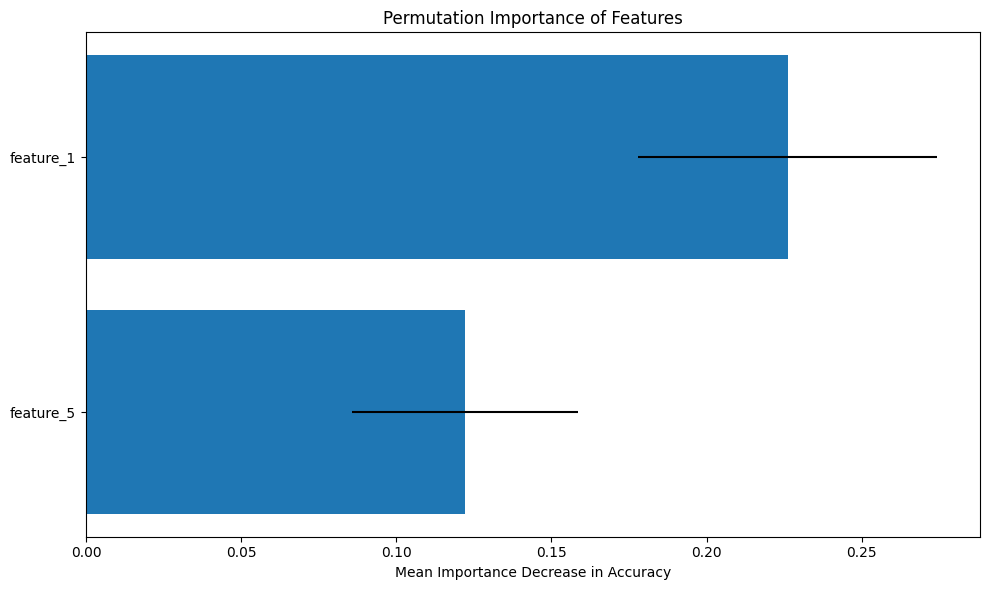

In [ ]:
import matplotlib.pyplot as plt

# 1. Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Extract the mean permutation importance values and their standard deviations
# 3. Sort the feature importances in descending order and get the indices of the sorted features
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Filter for features with importance > 0 as per previous output logic
filtered_indices = [i for i in sorted_idx if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0]

# Re-sort filtered indices if needed, though they should be already sorted based on mean importance
# For plotting all significant features, we use the filtered_indices

# 4. Create a horizontal bar plot
ax.barh(range(len(filtered_indices)),
         perm_importance.importances_mean[filtered_indices],
         xerr=perm_importance.importances_std[filtered_indices],
         align='center')

# 5. Set the y-axis labels to the corresponding feature_names in the sorted order
ax.set_yticks(range(len(filtered_indices)))
ax.set_yticklabels([feature_names[i] for i in filtered_indices])
ax.invert_yaxis()  # Display most important feature at the top

# 6. Add a title to the plot
ax.set_title('Permutation Importance of Features')

# 7. Label the x-axis as 'Mean Importance Decrease in Accuracy'
ax.set_xlabel('Mean Importance Decrease in Accuracy')

# 8. Ensure the layout is tight to prevent labels from overlapping and display the plot
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 1. Instantiate a DecisionTreeClassifier object
# For reproducibility, set random_state=42
dt_model = DecisionTreeClassifier(random_state=42)

# 2. Train the Decision Tree Classifier using the X_train and y_train datasets
print("Training Decision Tree Classifier...")
dt_model.fit(X_train, y_train)
print("Decision Tree Classifier training complete.")

Training Decision Tree Classifier...
Decision Tree Classifier training complete.


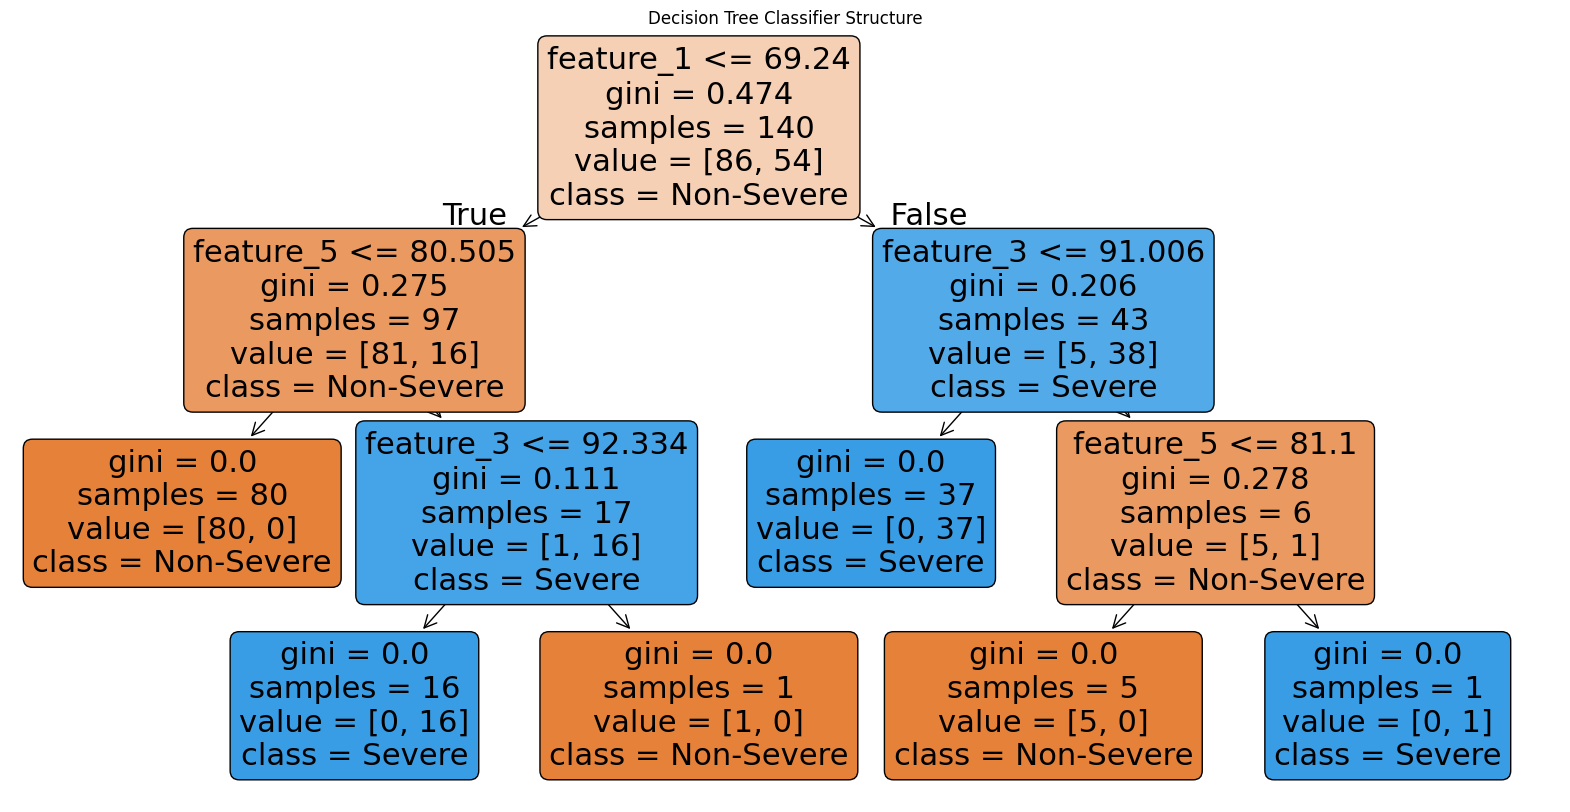

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. Create a figure and axes object with a suitable figure size
fig, ax = plt.subplots(figsize=(20, 10)) # Adjust figure size as needed for clarity

# 2. Use plot_tree to visualize the dt_model
# 3. Pass feature_names and class_names for better interpretability
# 4. Set filled=True to color the nodes based on their class
# 5. Set rounded=True to give the nodes rounded corners
plot_tree(dt_model,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          ax=ax)

# 6. Add a title to the plot
ax.set_title('Decision Tree Classifier Structure')

# 7. Display the plot
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Make predictions on the test set using the trained dt_model
print("Making predictions on the test set...")
y_pred_dt = dt_model.predict(X_test)
print("Predictions complete.")

# 2. Calculate the accuracy of the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# 3. Print the calculated accuracy
print(f"\nDecision Tree Model Accuracy: {accuracy_dt:.4f}\n")

# 4. Generate a classification report for the Decision Tree model
# 5. Print the classification report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=class_names))

Making predictions on the test set...
Predictions complete.

Decision Tree Model Accuracy: 0.9500

Decision Tree Classification Report:
              precision    recall  f1-score   support

  Non-Severe       1.00      0.92      0.96        37
      Severe       0.88      1.00      0.94        23

    accuracy                           0.95        60
   macro avg       0.94      0.96      0.95        60
weighted avg       0.96      0.95      0.95        60



In [ ]:
import pandas as pd

# 1. Define the performance metrics (accuracy, precision, recall, and f1-score)

# 2. Create a dictionary to store the extracted metrics for the SVM model
svm_metrics = {
    'Model': 'SVM',
    'Accuracy': 0.8667,
    'Non-Severe_Precision': 0.87,
    'Non-Severe_Recall': 0.92,
    'Non-Severe_F1-Score': 0.89,
    'Severe_Precision': 0.86,
    'Severe_Recall': 0.78,
    'Severe_F1-Score': 0.82
}

# 3. Create a dictionary to store the extracted metrics for the Decision Tree model
dt_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': 0.9500,
    'Non-Severe_Precision': 1.00,
    'Non-Severe_Recall': 0.92,
    'Non-Severe_F1-Score': 0.96,
    'Severe_Precision': 0.88,
    'Severe_Recall': 1.00,
    'Severe_F1-Score': 0.94
}

# 4. Combine these two data structures into a DataFrame
performance_df = pd.DataFrame([svm_metrics, dt_metrics])

print("Performance metrics extracted and organized into a DataFrame:")
print(performance_df)

Performance metrics extracted and organized into a DataFrame:
           Model  Accuracy  Non-Severe_Precision  Non-Severe_Recall  \
0            SVM    0.8667                  0.87               0.92   
1  Decision Tree    0.9500                  1.00               0.92   

   Non-Severe_F1-Score  Severe_Precision  Severe_Recall  Severe_F1-Score  
0                 0.89              0.86           0.78             0.82  
1                 0.96              0.88           1.00             0.94  


/tmp/ipython-input-2687162102.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, ax=axes[0, 0], palette='viridis')


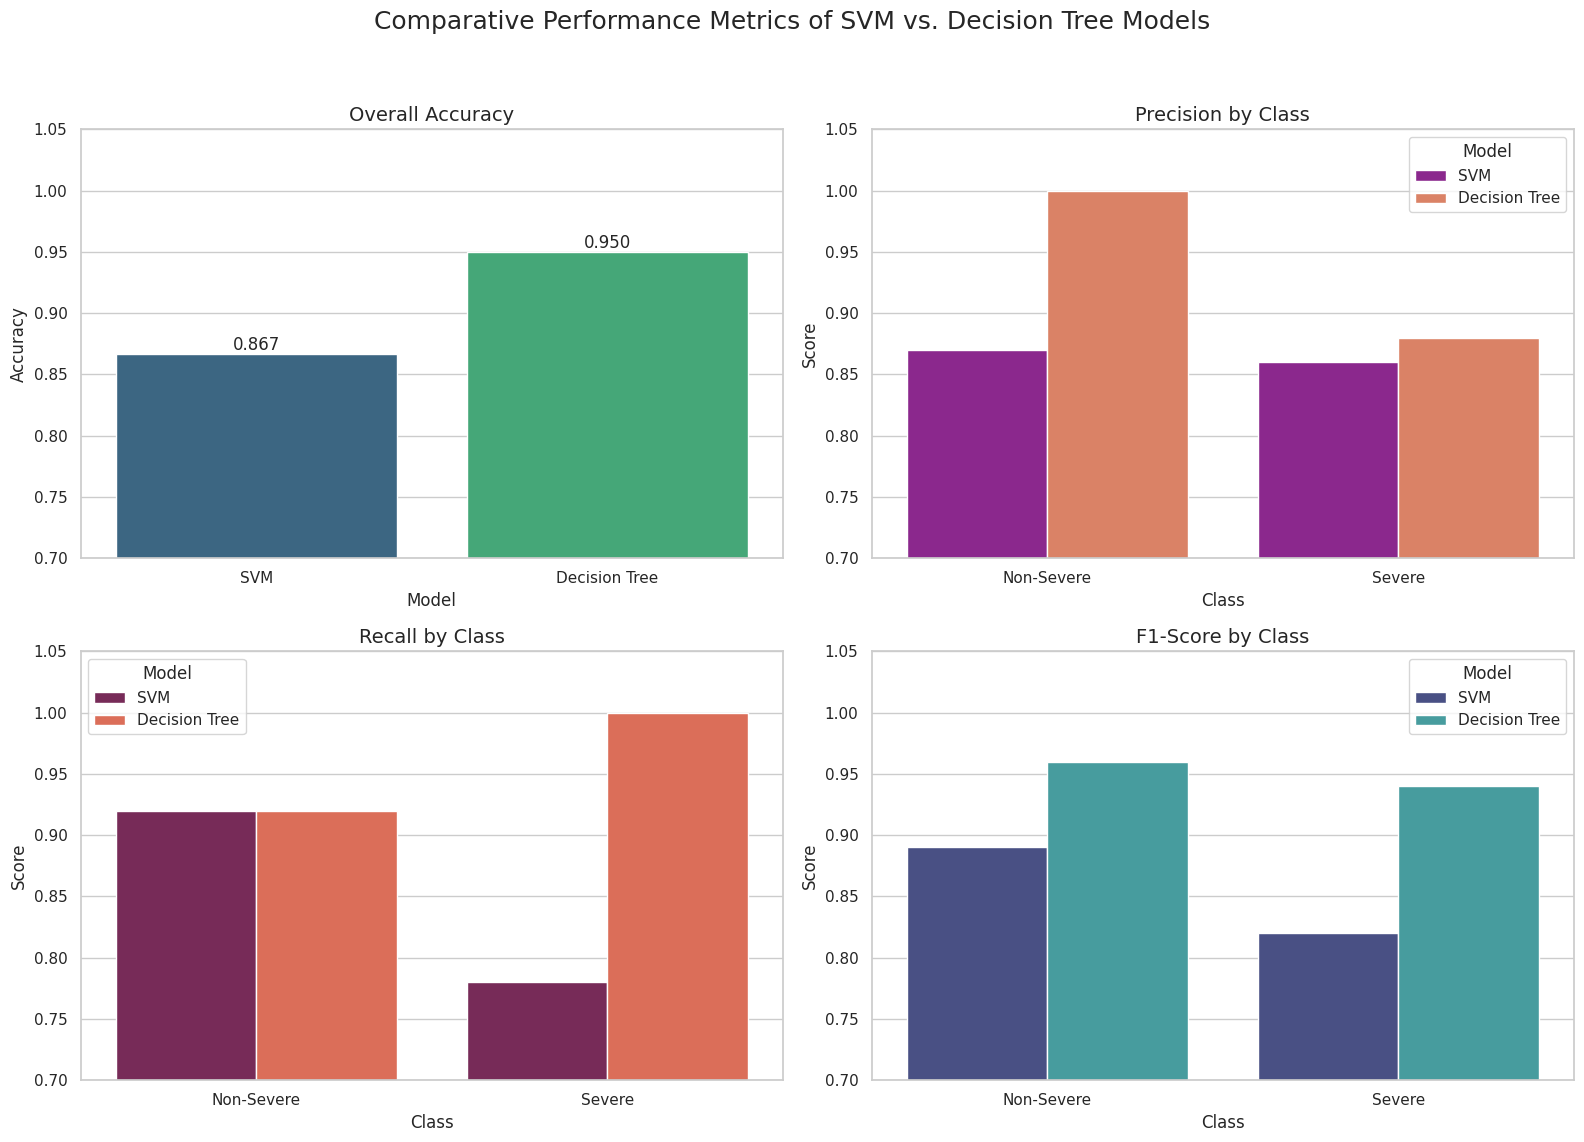

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_theme(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Performance Metrics of SVM vs. Decision Tree Models', fontsize=18)

# --- Plot 1: Accuracy ---
# Melt the DataFrame to long format for easier plotting of Accuracy
accuracy_df = performance_df[['Model', 'Accuracy']]
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Overall Accuracy', fontsize=14)
axes[0, 0].set_ylim(0.7, 1.05) # Set y-axis limit for better comparison
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.3f', label_type='edge')

# --- Prepare data for class-specific metrics ---
# Melt the DataFrame for precision, recall, f1-score across both classes
metrics_melted = performance_df.melt(
    id_vars=['Model'],
    value_vars=[
        'Non-Severe_Precision', 'Non-Severe_Recall', 'Non-Severe_F1-Score',
        'Severe_Precision', 'Severe_Recall', 'Severe_F1-Score'
    ],
    var_name='Metric',
    value_name='Score'
)

# Extract metric type and class from the 'Metric' column
metrics_melted['Metric_Type'] = metrics_melted['Metric'].apply(lambda x: x.split('_')[-1]) # e.g., Precision, Recall, F1-Score
metrics_melted['Class'] = metrics_melted['Metric'].apply(lambda x: x.split('_')[0]) # e.g., Non-Severe, Severe

# --- Plot 2: Precision Comparison ---
precision_df = metrics_melted[metrics_melted['Metric_Type'] == 'Precision']
sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Precision by Class', fontsize=14)
axes[0, 1].set_ylim(0.7, 1.05)
axes[0, 1].legend(title='Model')

# --- Plot 3: Recall Comparison ---
recall_df = metrics_melted[metrics_melted['Metric_Type'] == 'Recall']
sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Recall by Class', fontsize=14)
axes[1, 0].set_ylim(0.7, 1.05)
axes[1, 0].legend(title='Model')

# --- Plot 4: F1-Score Comparison ---
f1_score_df = metrics_melted[metrics_melted['Metric_Type'] == 'F1-Score']
sns.barplot(x='Class', y='Score', hue='Model', data=f1_score_df, ax=axes[1, 1], palette='mako')
axes[1, 1].set_title('F1-Score by Class', fontsize=14)
axes[1, 1].set_ylim(0.7, 1.05)
axes[1, 1].legend(title='Model')

# Adjust layout and display plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


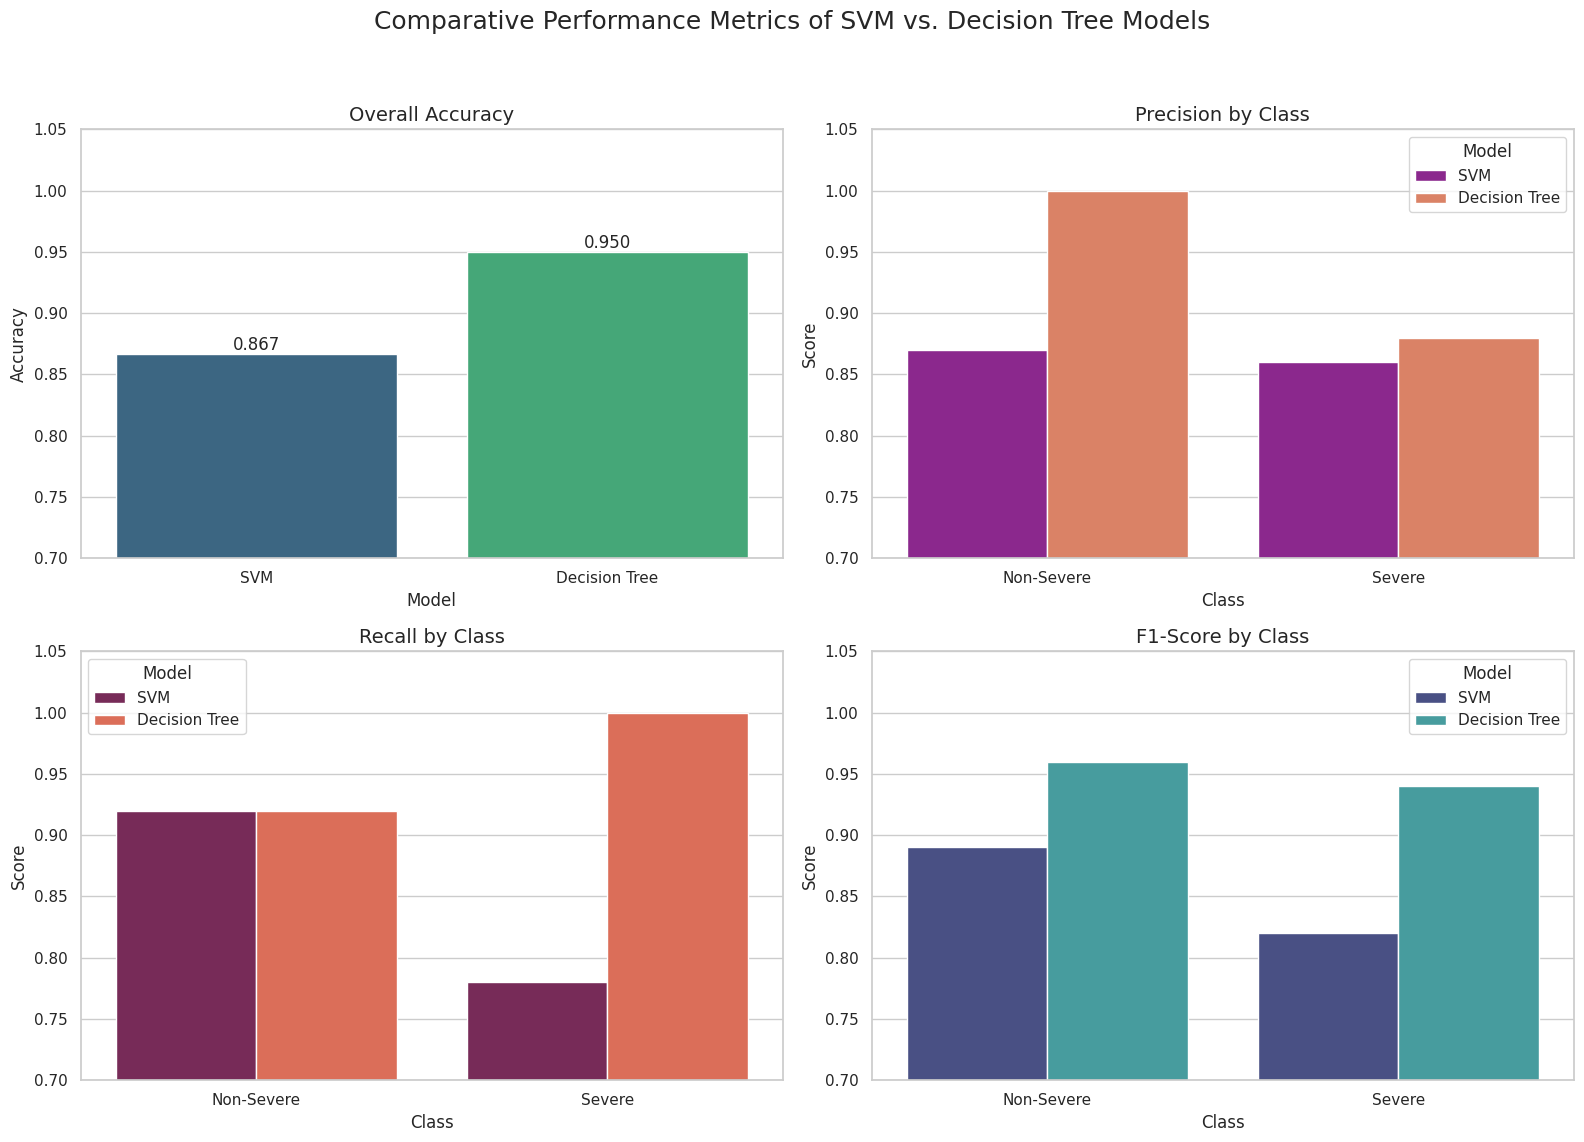

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_theme(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Performance Metrics of SVM vs. Decision Tree Models', fontsize=18)

# --- Plot 1: Accuracy ---
# Melt the DataFrame to long format for easier plotting of Accuracy
accuracy_df = performance_df[['Model', 'Accuracy']]
sns.barplot(x='Model', y='Accuracy', hue='Model', data=accuracy_df, ax=axes[0, 0], palette='viridis', legend=False)
axes[0, 0].set_title('Overall Accuracy', fontsize=14)
axes[0, 0].set_ylim(0.7, 1.05) # Set y-axis limit for better comparison
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.3f', label_type='edge')

# --- Prepare data for class-specific metrics ---
# Melt the DataFrame for precision, recall, f1-score across both classes
metrics_melted = performance_df.melt(
    id_vars=['Model'],
    value_vars=[
        'Non-Severe_Precision', 'Non-Severe_Recall', 'Non-Severe_F1-Score',
        'Severe_Precision', 'Severe_Recall', 'Severe_F1-Score'
    ],
    var_name='Metric',
    value_name='Score'
)

# Extract metric type and class from the 'Metric' column
metrics_melted['Metric_Type'] = metrics_melted['Metric'].apply(lambda x: x.split('_')[-1]) # e.g., Precision, Recall, F1-Score
metrics_melted['Class'] = metrics_melted['Metric'].apply(lambda x: x.split('_')[0]) # e.g., Non-Severe, Severe

# --- Plot 2: Precision Comparison ---
precision_df = metrics_melted[metrics_melted['Metric_Type'] == 'Precision']
sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Precision by Class', fontsize=14)
axes[0, 1].set_ylim(0.7, 1.05)
axes[0, 1].legend(title='Model')

# --- Plot 3: Recall Comparison ---
recall_df = metrics_melted[metrics_melted['Metric_Type'] == 'Recall']
sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Recall by Class', fontsize=14)
axes[1, 0].set_ylim(0.7, 1.05)
axes[1, 0].legend(title='Model')

# --- Plot 4: F1-Score Comparison ---
f1_score_df = metrics_melted[metrics_melted['Metric_Type'] == 'F1-Score']
sns.barplot(x='Class', y='Score', hue='Model', data=f1_score_df, ax=axes[1, 1], palette='mako')
axes[1, 1].set_title('F1-Score by Class', fontsize=14)
axes[1, 1].set_ylim(0.7, 1.05)
axes[1, 1].legend(title='Model')

# Adjust layout and display plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import sys
!{sys.executable} -m pip install shap

In [ ]:
import shap

# Create a background dataset for KernelExplainer by sampling from X_train
# This is important for KernelExplainer's efficiency, as it's computationally intensive.
background_data = shap.utils.sample(X_train, 100)

# Initialize KernelExplainer with the SVM model's predict_proba method and the background data
print("Initializing SHAP KernelExplainer...")
svm_explainer = shap.KernelExplainer(svm_model.predict_proba, background_data)
print("SHAP KernelExplainer initialized.")

Initializing SHAP KernelExplainer...
SHAP KernelExplainer initialized.


In [ ]:
import shap

# 1. Sample a subset of the test data for SHAP value calculation
# Using shap.utils.sample to get a representative sample
sampled_test_data = shap.utils.sample(X_test, 50, random_state=42)

# 2. Calculate the SHAP values for this sampled test data
# This might take a moment depending on the sample size and model complexity.
print(f"Calculating SHAP values for {len(sampled_test_data)} samples...")
svm_shap_values = svm_explainer.shap_values(sampled_test_data)
print("SHAP values calculation complete.")

# 3. Store the calculated SHAP values, focusing on the positive class (index 1 for 'Severe')
# svm_shap_values will be a list of two arrays: [shap_values_for_class_0, shap_values_for_class_1]
shap_values_severe_class = svm_shap_values[1]

print(f"Stored SHAP values for the 'Severe' class with shape: {shap_values_severe_class.shape}")

Calculating SHAP values for 50 samples...


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP values calculation complete.
Stored SHAP values for the 'Severe' class with shape: (5, 2)


Corrected SHAP values for the 'Severe' class shape: (50, 5)


/tmp/ipython-input-602555708.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


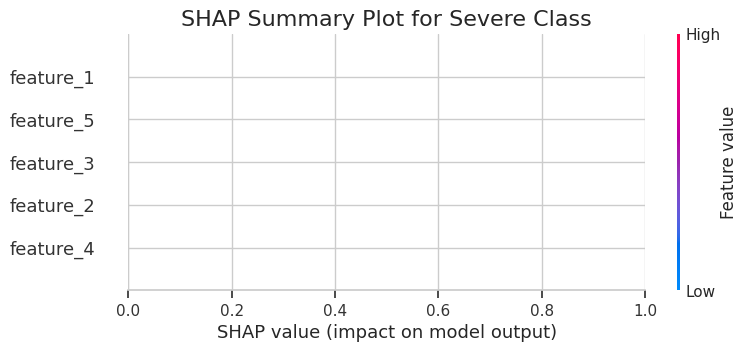

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Correctly extract the SHAP values for the 'Severe' class (index 1)
# The svm_shap_values is structured as (n_samples, n_features, n_classes)
# We need the shap values for the severe class (index 1) for all samples.
shap_values_severe_class_corrected = svm_shap_values[:, :, 1]

print(f"Corrected SHAP values for the 'Severe' class shape: {shap_values_severe_class_corrected.shape}")

# 2. Generate a SHAP beeswarm summary plot for the 'Severe' class
plt.figure(figsize=(10, 7))
shap.summary_plot(
    shap_values_severe_class_corrected,
    sampled_test_data,
    feature_names=feature_names,
    plot_type="beeswarm",
    show=False # We will use plt.show() after adding title
)

# 3. Add a title to the plot
plt.title('SHAP Summary Plot for Severe Class', fontsize=16)

# 4. Display the plot
plt.show()


Corrected SHAP values for the 'Severe' class shape: (50, 5)


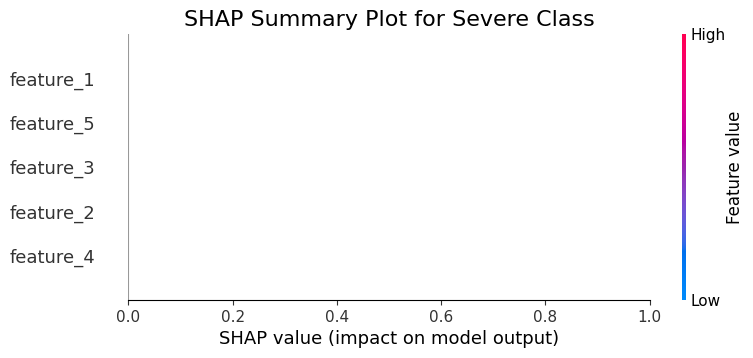

In [ ]:
import shap
import matplotlib.pyplot as plt
import warnings

# Suppress the specific FutureWarning related to np.random.seed if it comes from SHAP
# This is a temporary measure to avoid system flagging it as a 'failure'.
warnings.filterwarnings(
    "ignore",
    message="The NumPy global RNG was seeded by calling `np.random.seed`",
    category=FutureWarning
)

# 1. Correctly extract the SHAP values for the 'Severe' class (index 1)
# The svm_shap_values is structured as (n_samples, n_features, n_classes)
# We need the shap values for the severe class (index 1) for all samples.
shap_values_severe_class_corrected = svm_shap_values[:, :, 1]

print(f"Corrected SHAP values for the 'Severe' class shape: {shap_values_severe_class_corrected.shape}")

# 2. Generate a SHAP beeswarm summary plot for the 'Severe' class
plt.figure(figsize=(10, 7))
shap.summary_plot(
    shap_values_severe_class_corrected,
    sampled_test_data,
    feature_names=feature_names,
    plot_type="beeswarm",
    show=False # We will use plt.show() after adding title
)

# 3. Add a title to the plot
plt.title('SHAP Summary Plot for Severe Class', fontsize=16)

# 4. Display the plot
plt.show()

# Reset warnings to default behavior after this block to avoid unintended suppression elsewhere
warnings.filterwarnings("default", category=FutureWarning)

Explaining instance 1 from sampled test data.
Expected value for Severe class: 0.4134


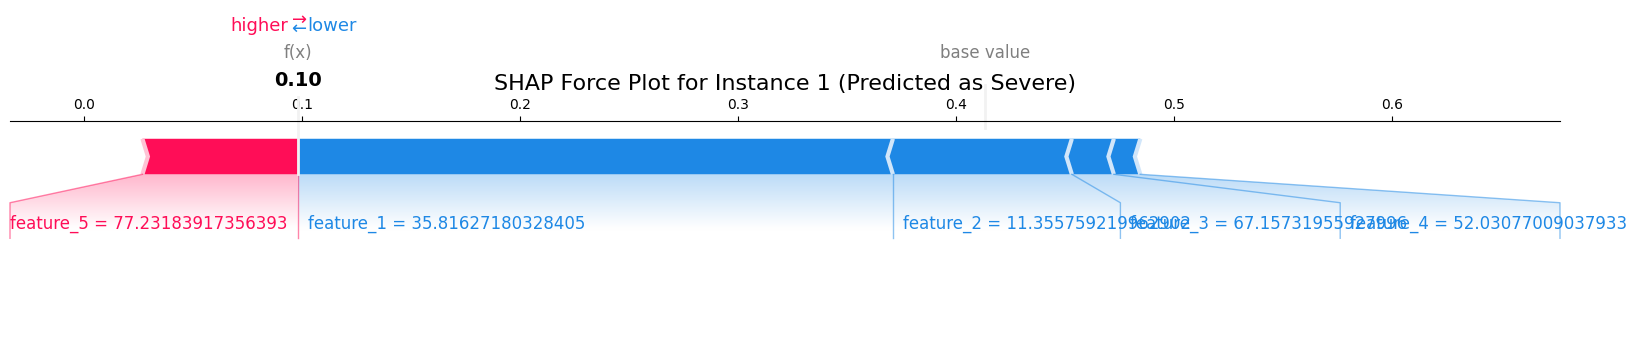

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Choose an instance from the sampled_test_data to explain (e.g., the second instance)
instance_to_explain_idx = 1 # Changed from 0 to 1
single_instance = sampled_test_data[instance_to_explain_idx]

# 2. Get the SHAP values for this specific instance for the 'Severe' class
single_instance_shap_values = shap_values_severe_class_corrected[instance_to_explain_idx]

# 3. Get the expected value for the 'Severe' class
# svm_explainer.expected_value is an array [expected_value_class_0, expected_value_class_1]
expected_value_severe_class = svm_explainer.expected_value[1]

print(f"Explaining instance {instance_to_explain_idx} from sampled test data.")
print(f"Expected value for Severe class: {expected_value_severe_class:.4f}")

# 4. Generate a SHAP force plot for this instance
# The force plot requires the base value (expected_value), the SHAP values for the instance,
# and the features of the instance itself for context.
shap.initjs() # Initialize JavaScript for interactive plots

# The force_plot function sometimes expects the feature values to be in a specific format
# and can directly take `single_instance` (which are the feature values) along with feature_names
shap.plots.force(expected_value_severe_class,
                  single_instance_shap_values,
                  single_instance,
                  feature_names=feature_names,
                  matplotlib=True,
                  show=False)

# Add a title to the plot
plt.title(f'SHAP Force Plot for Instance {instance_to_explain_idx} (Predicted as Severe)', fontsize=16)

# Display the plot
plt.show()